# 3D Rendering in Python
This notebook will go through the process of building a basic 3d rendering using Python. The idea is to manually do the rasterisation using some 2d Python functions in order to learn the process of 3d rendering. Initially the rendering will be done on CPU however I plan to add hardware acceleration afterwards.

In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [2]:
# Read in obj file and
# Return an array of vertices and faces
# (Ignore normals and materials for now)
def load_obj_file(filename):
    verts = []
    faces = []
    
    file = open(filename)
    for line in file:
        if not len(line.strip()): 
            continue
        line_type = line.strip().split()[0]
        line_elements = line.strip().split()[1:]
        # Look for vertices and add to verts list
        if line_type == 'v':
            verts.append([float(le) for le in line_elements])
        # Look for faces and add to faces list
        elif line_type == 'f':
            faces.append([int(le.split('/')[0]) for le in line_elements])
    return verts, faces

# Load an obj file
verts, faces = load_obj_file("models/teapot/teapot.obj")
print(f'Loaded: {len(verts)} verts, {len(faces)} faces')

Loaded: 7850 verts, 8028 faces


In [3]:
# Set up the scene world coordinates
# Right handed coordinate system
# X - Right is positive direction
# Y - Up is positive direction
# Z - Positive direction is "out of the screen"
class SceneCoords():
    def __init__(self, x_0, x_1, y_0, y_1, z_0, z_1):
        self.x_0, self.x_1 = x_0, x_1
        self.y_0, self.y_1 = y_0, y_1
        self.z_0, self.z_1 = z_0, z_1

# Find the world coordinates to used from the model
def scene_coords_from_model(verts):
    verts_np = np.array(verts)
    x_0, y_0, z_0 = verts_np.min(axis=0)
    x_1, y_1, z_1 = verts_np.max(axis=0)
    return SceneCoords(x_0, x_1, y_0, y_1, z_0, z_1)
    
# Create a new scene
scene = scene_coords_from_model(verts)

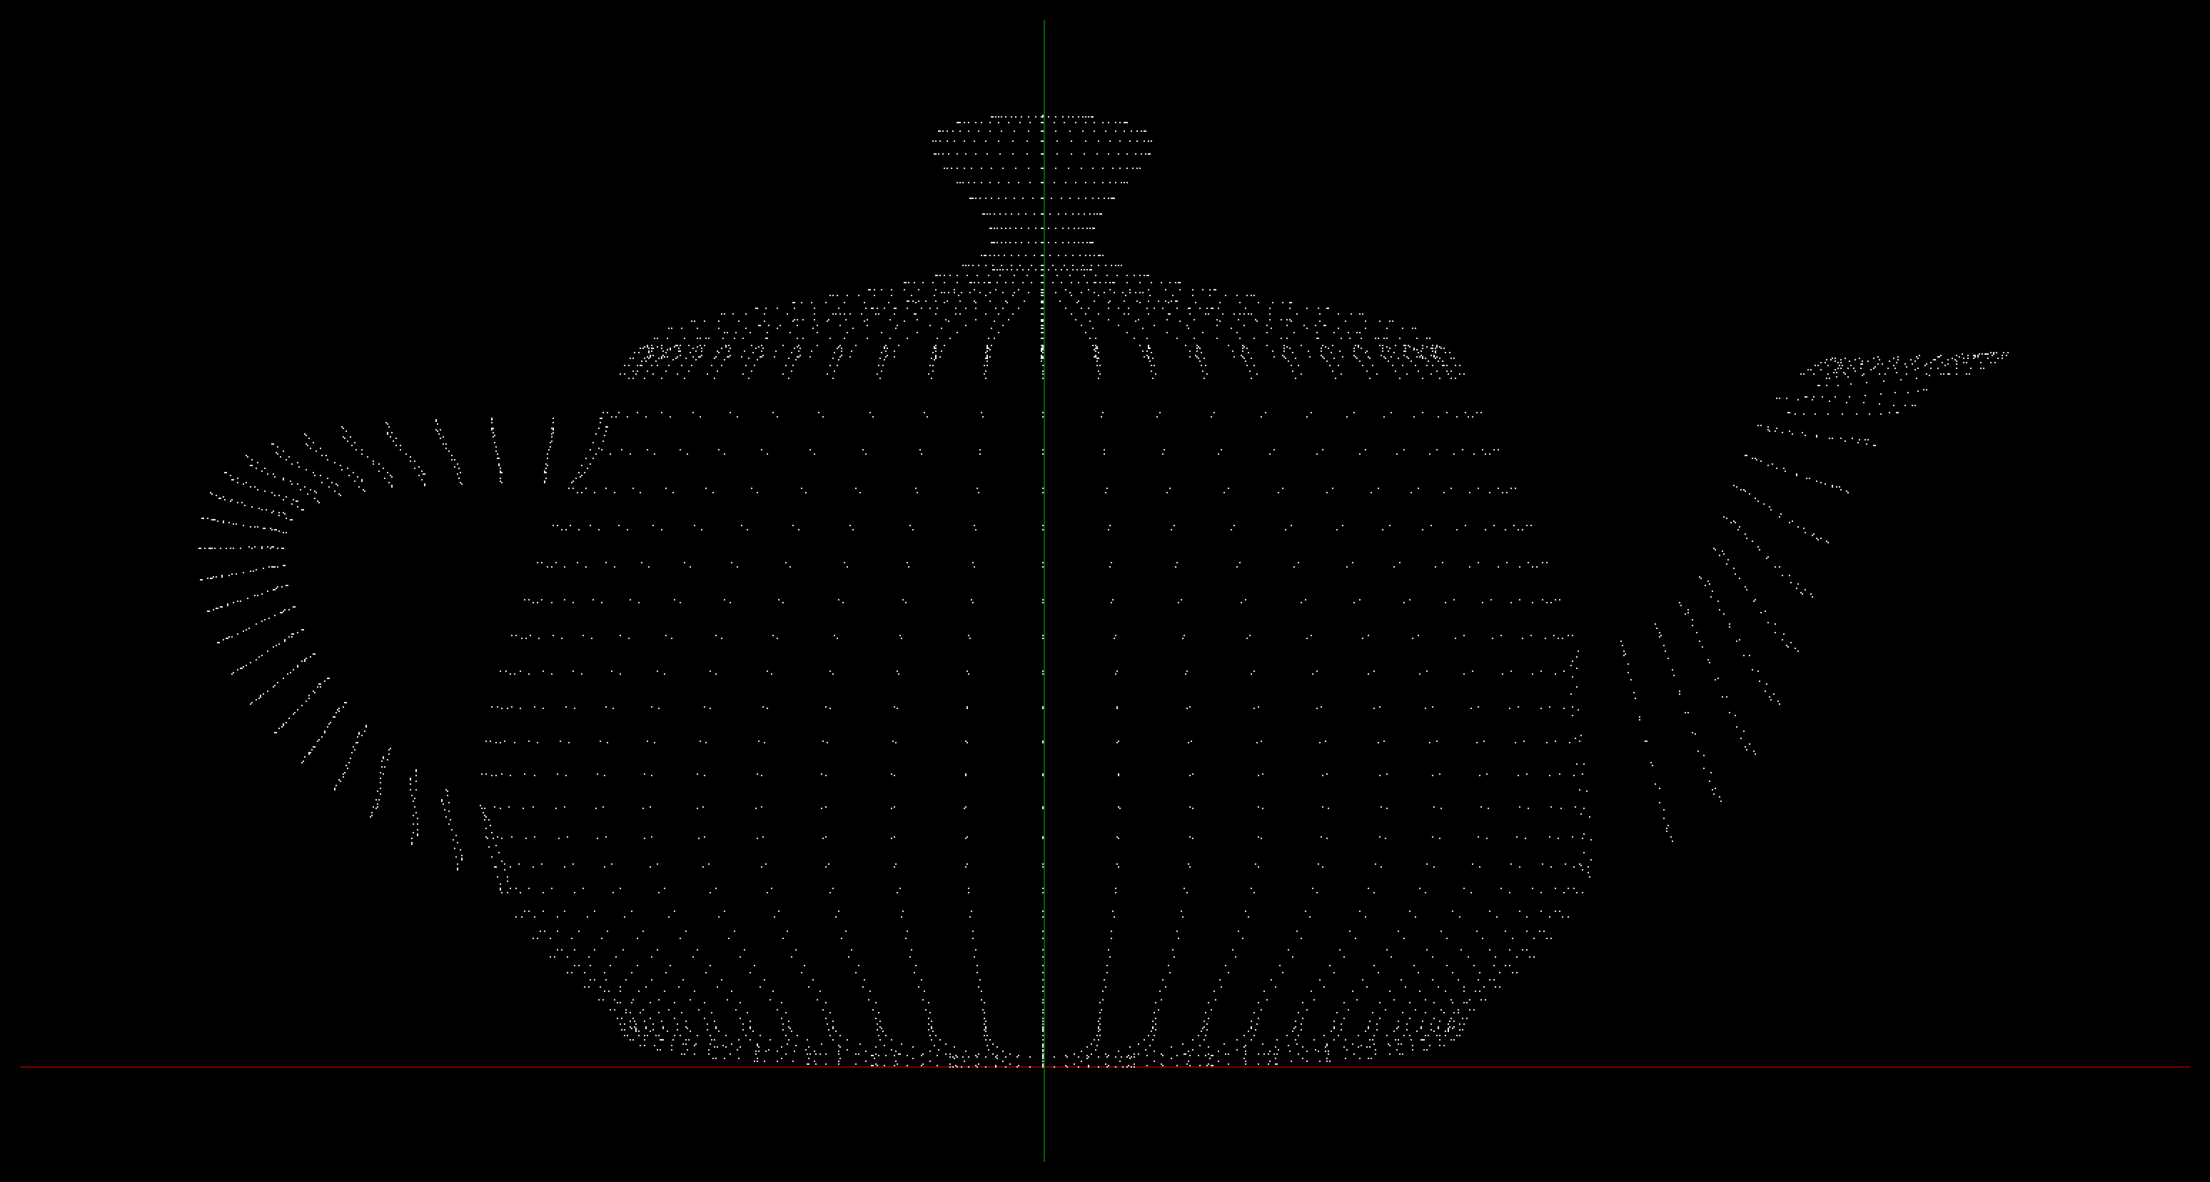

In [11]:
# Render the 3d object from an orthographic viewpoint
# Returns a rendered image
def orthographic_render(scene, verts, faces, axis='z', zoom=1.0, height=768, width=1024):
    # Calculate pixels per world units (horizontal and vertical)
    # and screen coordinates of origin
    offset_h = width * (zoom-1.0) / (2.0*zoom)
    offset_v = height * (zoom-1.0) / (2.0*zoom)
    
    if axis == 'z':
        # No inversion
        scale_h = width / (scene.x_1 - scene.x_0) / zoom
        scale_v = height / (scene.y_1 - scene.y_0) / zoom
        origin_h = int(-(scene.x_0) * scale_h + offset_h)
        origin_v = int(-(scene.y_0) * scale_v + offset_v)
    elif axis == 'y':
        # Invert z
        scale_h = width / (scene.x_1 - scene.x_0) / zoom
        scale_v = height / (scene.z_1 - scene.z_0) / zoom
        origin_h = int(-(scene.x_0) * scale_h + offset_h)
        origin_v = int(-(scene.z_0) * scale_v + offset_v)
    elif axis == 'x':
        # Invert z
        scale_h = width / (scene.z_1 - scene.z_0) / zoom
        scale_v = height / (scene.y_1 - scene.y_0) / zoom
        origin_h = int(-(scene.z_0) * scale_h + offset_h)
        origin_v = int(-(scene.y_0) * scale_v + offset_v)

    # Numpy format (h, w, c)
    # Set all pixels to black
    image = np.zeros((height, width, 3), dtype='float')

    # Axes colours
    if axis == 'z':
        h_colour = [0.5, 0.0, 0.0]
        v_colour = [0.0, 0.4, 0.0]
    elif axis == 'y':
        h_colour = [0.5, 0.0, 0.0]
        v_colour = [0.0, 0.0, 0.5]
    elif axis == 'x':
        h_colour = [0.0, 0.0, 0.5]
        v_colour = [0.0, 0.4, 0.0]
    
    # Draw axes
    for x in range(width):
        image[height-origin_v-1, x, : ] = h_colour
    for y in range(height):
        image[height-y-1, origin_h, : ] = v_colour

    # Draw the verts in white
    if axis == 'z':
        for v in verts:
            image[height-int(v[1]*scale_v + origin_v)-1,int(v[0]*scale_h + origin_h)-1,:] = 1.0
    if axis == 'y':
        for v in verts:
            image[height-int(v[2]*scale_v + origin_v)-1,int(v[0]*scale_h + origin_h)-1,:] = 1.0
    if axis == 'x':
        for v in verts:
            image[height-int(v[1]*scale_v + origin_v)-1,int(v[2]*scale_h + origin_h)-1,:] = 1.0
    
    return image

def show_image(image_in, size=10):
    fix, ax = plt.subplots(figsize=(size,size))
    plt.style.use('dark_background')
    plt.axis('off')
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    ax.imshow(image_in)

# Let's try rendering the shape
rendered_image = orthographic_render(scene, verts, faces, axis='z', zoom=1.2, height=800, width=1520)
show_image(rendered_image, size=14)

We can now render an image from an axis orthogonal view, cool! Now what I would like to do is fill in the mesh by drawing the edges between vertices.

In [5]:
verts, faces = load_obj_file("models/teapot/teapot.obj")
print(f'Loaded: {len(verts)} verts, {len(faces)} faces')

# Create a new scene
scene = scene_coords_from_model(verts)

Loaded: 7850 verts, 8028 faces


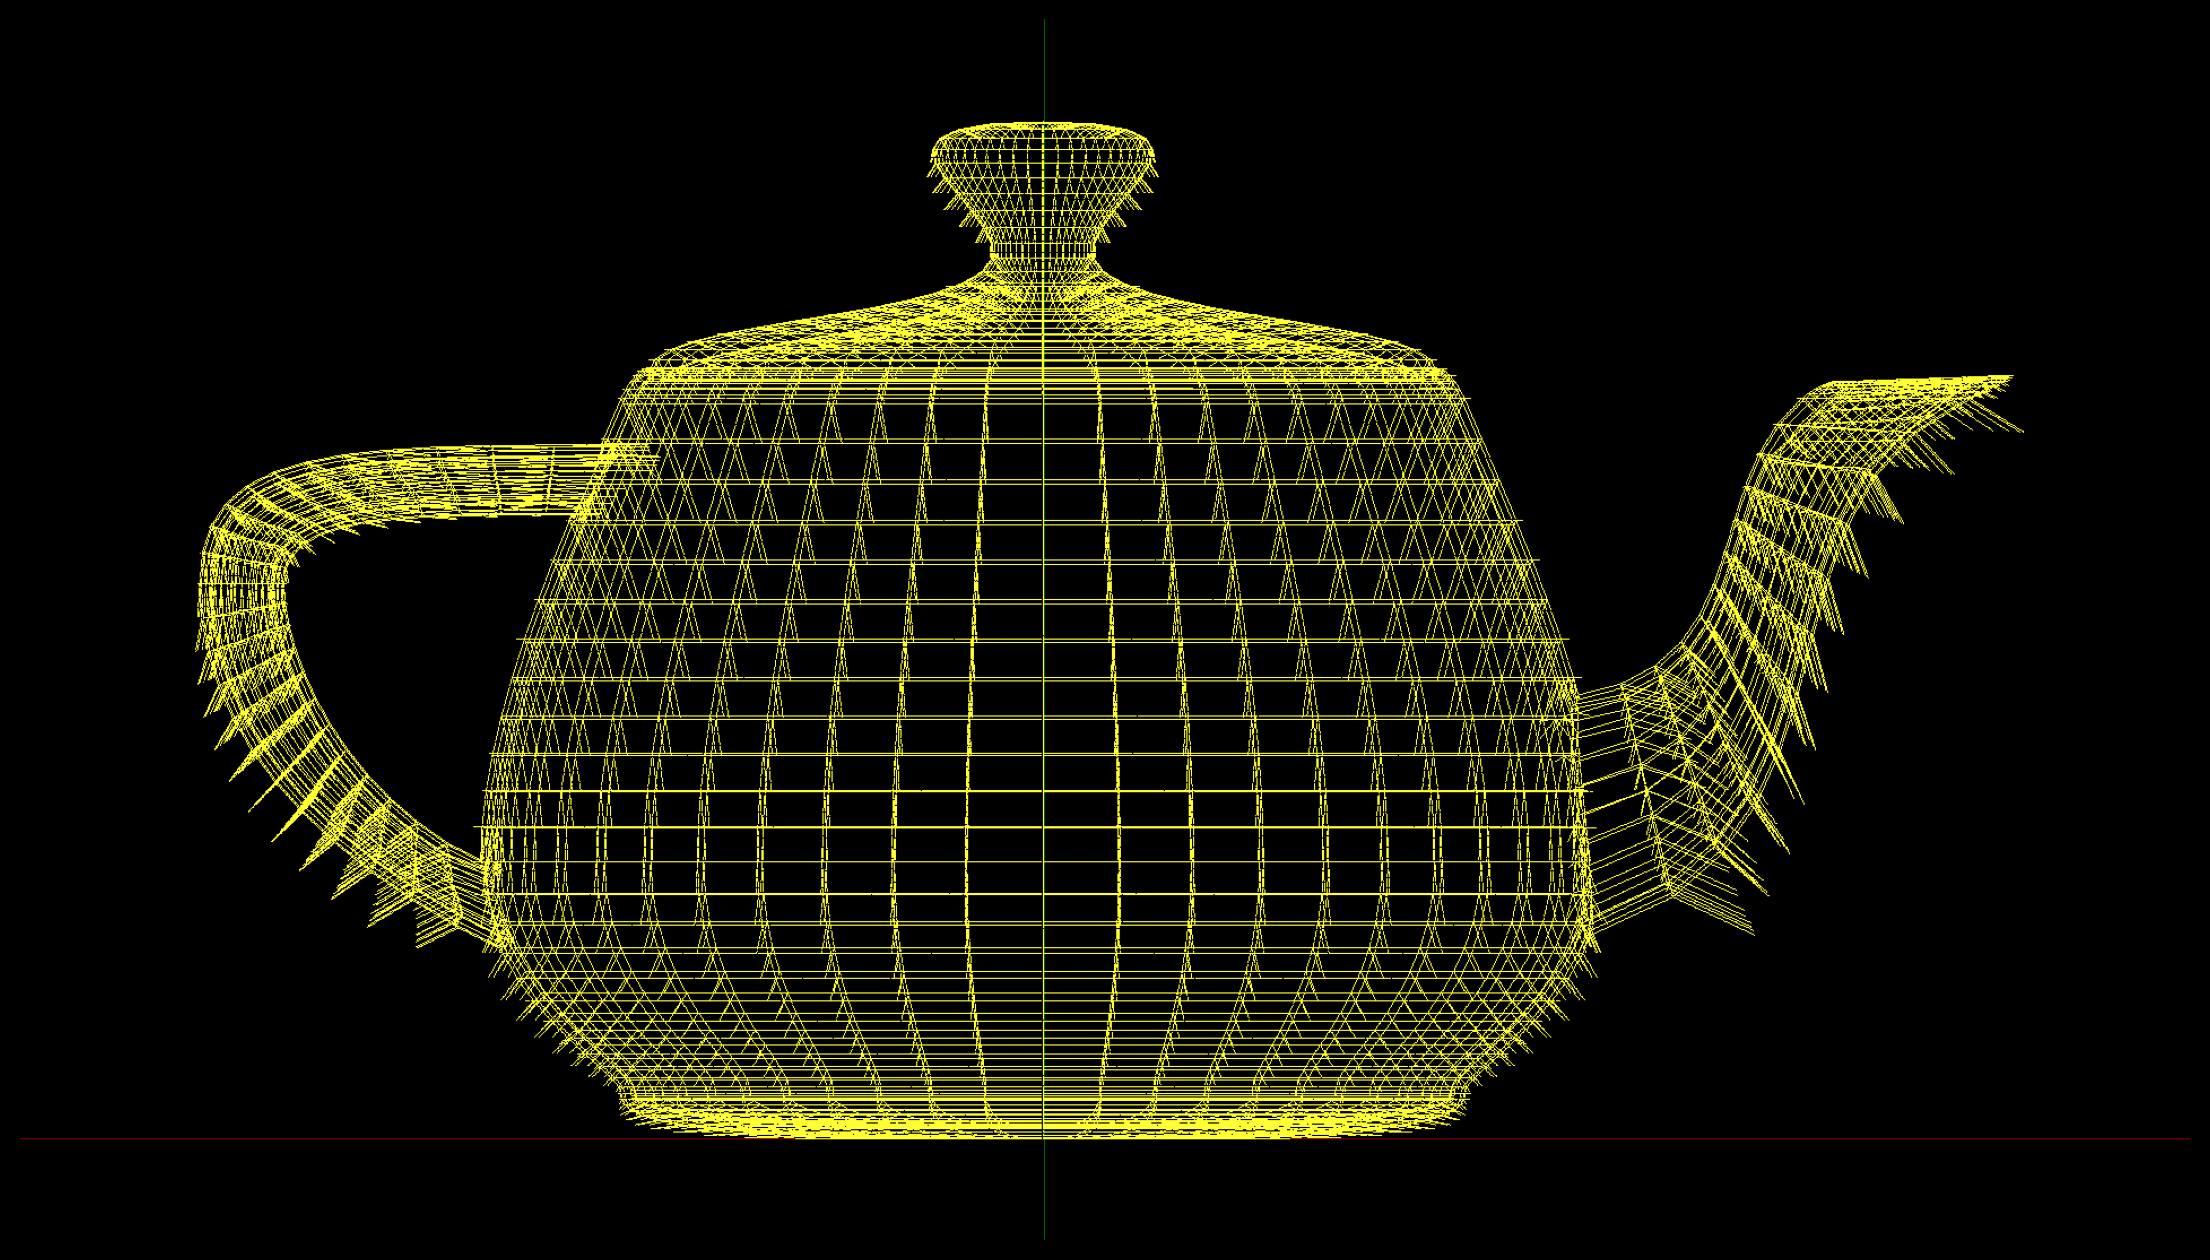

In [8]:
# Returns a rendered image
def orthographic_render(scene, verts, faces, axis='z', zoom=1.0, height=768, width=1024):
    # Calculate pixels per world units (horizontal and vertical)
    # and screen coordinates of origin
    offset_h = width * (zoom-1.0) / (2.0*zoom)
    offset_v = height * (zoom-1.0) / (2.0*zoom)
    
    if axis == 'z':
        # No inversion
        scale_h = width / (scene.x_1 - scene.x_0) / zoom
        scale_v = height / (scene.y_1 - scene.y_0) / zoom
        origin_h = int(-(scene.x_0) * scale_h + offset_h)
        origin_v = int(-(scene.y_0) * scale_v + offset_v)
    elif axis == 'y':
        # Invert z
        scale_h = width / (scene.x_1 - scene.x_0) / zoom
        scale_v = height / (scene.z_1 - scene.z_0) / zoom
        origin_h = int(-(scene.x_0) * scale_h + offset_h)
        origin_v = int(-(scene.z_0) * scale_v + offset_v)
    elif axis == 'x':
        # Invert z
        scale_h = width / (scene.z_1 - scene.z_0) / zoom
        scale_v = height / (scene.y_1 - scene.y_0) / zoom
        origin_h = int(-(scene.z_0) * scale_h + offset_h)
        origin_v = int(-(scene.y_0) * scale_v + offset_v)
    
    # Numpy format (h, w, c)
    # Set all pixels to black
    image = np.zeros((height, width, 3), dtype='float')

    # Axes colours
    if axis == 'z':
        h_colour = [0.5, 0.0, 0.0]
        v_colour = [0.0, 0.4, 0.0]
    elif axis == 'y':
        h_colour = [0.5, 0.0, 0.0]
        v_colour = [0.0, 0.0, 0.5]
    elif axis == 'x':
        h_colour = [0.0, 0.0, 0.5]
        v_colour = [0.0, 0.4, 0.0]
    
    # Draw axes
    for x in range(width):
        image[height-origin_v-1, x, : ] = h_colour
    for y in range(height):
        image[height-y-1, origin_h, : ] = v_colour

    # Draw the verts in white
    if axis == 'z':
        for v in verts:
            image[height-int(v[1]*scale_v + origin_v)-1,int(v[0]*scale_h + origin_h)-1,:] = 1.0
    if axis == 'y':
        for v in verts:
            image[height-int(v[2]*scale_v + origin_v)-1,int(v[0]*scale_h + origin_h)-1,:] = 1.0
    if axis == 'x':
        for v in verts:
            image[height-int(v[1]*scale_v + origin_v)-1,int(v[2]*scale_h + origin_h)-1,:] = 1.0

    # Draw eges in yellow
    # Note: need to improve efficiency by only drawing shared edges once
    for face in faces:
        vs = [verts[face[i]-1] for i, v in enumerate(face)]
        
        for vi in range(len(vs)):
            x_axis = [1,0]
            p1 = [vs[vi][0],vs[vi][1]]
            if vi == len(vs)-1:
                p2 = [vs[0][0],vs[0][1]]
            else:
                p2 = [vs[vi+1][0],vs[vi+1][1]]
            xl = p2[0]-p1[0]
            yl = p2[1]-p1[1]
        
            magnitude = lambda x, y: (x**2 + y**2)**0.5
            length = magnitude(xl, yl)
            px = int(scale_h * length)
            theta = np.arccos(np.dot([xl,yl], x_axis) / magnitude(xl,yl)*magnitude(1.0,0.0))
            if yl < 0.0:
                theta += np.pi 
            
            for p in range(px):
                y_loc = int((p1[1] + length*p/px*np.sin(theta))*scale_v + origin_v)
                x_loc = int((p1[0] + length*p/px*np.cos(theta))*scale_h + origin_h)
                
                image[height - y_loc - 1, x_loc - 1,:] = [1.0, 1.0, 0.2]

    return image

# Let's try rendering the shape
rendered_image = orthographic_render(scene, verts, faces, axis='z', zoom=1.2, height=1080, width=1920)
show_image(rendered_image, size=14)